# Preliminary Analysis 

In [22]:
# In this notebook, we will load the data and perform preliminary analysis

In [23]:
# Open Spark session 
from pyspark.sql import SparkSession, functions as F


# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Data_Explorer")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [24]:
# Read the files 
transactions_sample = spark.read.parquet('../data/tables/transactions_20210228_20210827_snapshot')
consumer_details = spark.read.parquet('../data/tables/consumer_user_details.parquet')
merchants_tbl = spark.read.parquet('../data/tables/tbl_merchants.parquet')
customer_tbl = spark.read.option("delimiter", "|").option("header",True).csv('../data/tables/tbl_consumer.csv')

# Pre Process the tags column in tbl_merchants

In [25]:
merchants = merchants_tbl.toPandas()

In [26]:
import re
# this function standardises the tags attribute, creating a list with the 'description', 'revenue band' and 'BNPL service charge'
def tag_extract(tag_string): 
    # first need to preprocess
    string =  re.sub('\[','(', tag_string.lower())
    string = re.sub('\]',')', string)
    # break the string into sections
    string_cut = string.split('),')
    new_string = []
    # first extract the description 
    new_string.append(str(string_cut[0].strip('((')))
    # second extract the band
    new_string.append(str(re.search(r'[a-z]',string_cut[1]).group()))
    # finally the take rate
    new_string.append(float(re.search(r'[0-9]+\.[0-9]+',string_cut[2]).group()))
    return(new_string)
################
# now we can run the algorithm
tags = merchants['tags']
processed_tags = []
for i in tags:
    processed_tags.append(tag_extract(i))

In [27]:
import pandas as pd
merchant_tbl = pd.DataFrame(processed_tags, columns=('Description', 'Earnings_Class', 'BNPL_Fee'))
merchant_tbl = pd.concat([merchants, merchant_tbl], axis=1)
# drop the tags column 
merchant_tbl.drop(columns='tags', inplace=True)

In [28]:
# and convert back to spark dataframe 
merchants_tbl = spark.createDataFrame(merchant_tbl)

In [29]:
# This could be further expanded in breaking the discription up further

# continue as usual from here

In [30]:
customer_tbl = customer_tbl.join(consumer_details, ['consumer_id'])

In [31]:
full_dataset = transactions_sample.join(customer_tbl, ['user_id'])
merchants_tbl = merchants_tbl.withColumnRenamed('name','company_name')
full_dataset = full_dataset.join(merchants_tbl, ['merchant_abn'])

In [32]:
full_dataset.count()
# this is a reduction compared to the 3643266 from records

3494038

In [33]:
# lets add a day (mon,...), weekly & monthly attribute
import pyspark.sql.functions as F
full_dataset = full_dataset.withColumn('Day', F.dayofweek('order_datetime'))
full_dataset = full_dataset.withColumn('Month', F.month('order_datetime'))
# now we can also add the bnpl revenue from a transaction 
full_dataset = full_dataset.withColumn('BNPL_Revenue', F.col('dollar_value') * 0.01 * F.col('BNPL_Fee'))
full_dataset.createOrReplaceTempView('data')
# we can remove name, location and customerID for now, due to being unnnesesary attributes (although company_name could also be removed)
full_dataset = spark.sql("""
select merchant_abn, user_id, dollar_value, order_id, order_datetime, state, postcode, gender, company_name, 
        Description, Earnings_Class, BNPL_Fee, BNPL_Revenue, Day, Month, weekofyear(order_datetime) as weekofyear from data
""")

In [253]:
full_dataset.describe()

summary,merchant_abn,user_id,dollar_value,order_id,state,postcode,gender,company_name,Description,Earnings_Class,BNPL_Fee,BNPL_Revenue,Day,Month,weekofyear
count,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038,3494038
mean,5.585243624643691E10,12038.032943545548,158.60763205130922,null,null,4043.94900227187,null,null,null,null,4.588224930580222,7.081201336455867,4.031661647640925,5.557945563270921,21.86156590168739
stddev,2.523671447353545...,6951.607246286589,467.64218536055836,null,null,1780.253722239743,null,null,null,null,1.739166345211653,21.38484437435536,2.0035909259244025,1.6907165834585798,7.401907756460781
min,10023283211,1,9.756658099412162E-8,000000f8-6795-4d2...,ACT,1001,Female,A Aliquet Ltd,antique shops - ...,a,0.1,4.692952545817249...,1,2,8
max,99990536339,24081,105193.88578925544,fffffb2e-6809-44b...,WA,9999,Undisclosed,Vulputate Velit Inc.,"watch, clock, and...",e,7.0,3576.5921168346845,7,8,34


# Description of dataset
On first inspection, everything looks 'ok', but I have noticed a few things. 
1. there are unreasonalble values in the dataset
We can see that the minimum dollar value is approx. zero, whilst one is around 105193.88578925544 (and belings to the smallest band, hence a contradiction). This suggests that investigating what are 'real' purchases should be considered (like a fluke one of purchase isn't resonable to count)


The following investigaes the dollar_value attribute's distribution

In [256]:
gl = full_dataset.toPandas()

In [261]:
# this is to remove the 
gl = gl[gl['dollar_value'] > 10]

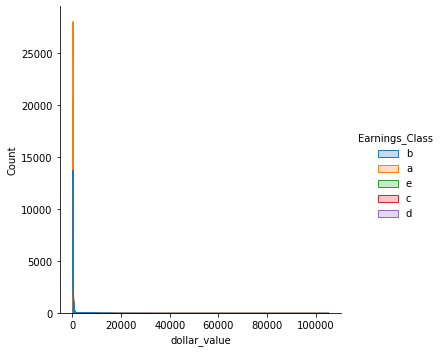

In [262]:
import seaborn as sns
sns.displot(x='dollar_value',hue='Earnings_Class',element="step", data=gl)

Continue with analysis

In [250]:
# now we can perform aggregation
full_dataset.createOrReplaceTempView('las')
top_100 = spark.sql("""
select company_name, sum(BNPL_Revenue) as BNPL_Revenue, Earnings_Class from las
group by company_name, Earnings_Class
order by BNPL_Revenue desc
limit 50
""")
top_100.createOrReplaceTempView('las1')
agg_data = spark.sql("""
select sum(BNPL_Revenue) as revenue, Month, company_name, Earnings_Class from las
group by Month, company_name, Earnings_Class
having company_name in (select company_name from las1)""")
# don't care about the top 50
agg_data2 = spark.sql("""
select sum(BNPL_Revenue) as revenue, company_name, Earnings_Class from las
group by company_name, Earnings_Class
""")

In [251]:
agg_data = agg_data.toPandas()
agg_data2 = agg_data2.toPandas()

[Text(0.5, 1.0, 'Comparison of Top 50 BNPL Revenue companies over time')]

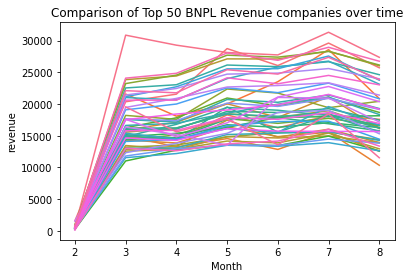

In [237]:
# This plot is to just examine the revenue over time of the top 'ranked' companies
import seaborn as sns
# can switch hue to Earnings_Class to see that a & b dominate top 50
g = sns.lineplot(x = 'Month', y = 'revenue', hue = 'company_name', data=agg_data, legend=False)
g.set(title='Comparison of Top 50 BNPL Revenue companies over time')
# we can see that these is a visible gab between each company, but further analysis would be good 

<AxesSubplot:xlabel='Earnings_Class', ylabel='revenue'>

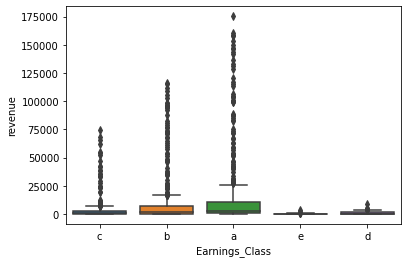

In [252]:
# Lets look at the distribution of total revenue of each company, and colured by revenue band
sns.boxplot(y='revenue', x='Earnings_Class', data=agg_data2)
# we can see that the all data is heavily left skewed??, with there visible 'outliers' for each revenue band. 
# taking the metric alone, a classed companies appear to produce the most BNPL money, but again when we start factoring in other 
# important measures, then we will have a better understanding.

In [ ]:
# Lets look at the total BNPL revenue from the whole timeline
earnings_distribution = spark.sql("""select Earnings_Class, sum(BNPL_Revenue) as BNPL_Revenue from las group by Earnings_Class""")
transaction_distribution = spark.sql("""select Earnings_Class, count(*) as Prop from las group by Earnings_Class""")

In [ ]:
earnings_distribution = earnings_distribution.toPandas()
transaction_distribution = transaction_distribution.toPandas()
# standardize the frequencies
divide = full_dataset.count()
transaction_distribution['Prop'] = transaction_distribution['Prop'] / divide

[Text(0.5, 1.0, 'Distribution of BNPL Revenue by company Class')]

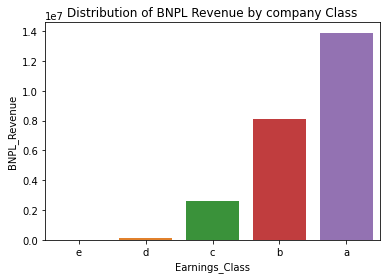

In [ ]:
# Lets look at the makeup of BNPL revenue by their Earnings band 
sns.barplot(x='Earnings_Class', y= 'BNPL_Revenue', data = earnings_distribution).set(title='Distribution of BNPL Revenue by company Class')

[Text(0.5, 1.0, 'Proportion of customer demand by earning class')]

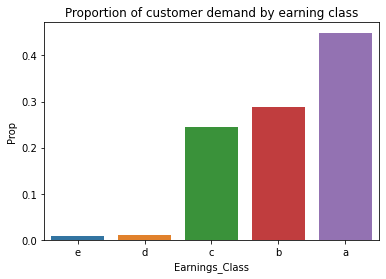

In [ ]:
# Lets look at the makeup of BNPL revenue by their Earnings band 
sns.barplot(x='Earnings_Class',y= 'Prop',data = transaction_distribution).set(title='Proportion of customer demand by earning class')

# Key findings so far
There a few things to point out from preliminary analysis so far. 

Firstly, from the line plot, we can see that the top 50 companies with the calculated BNPL revenue have a noticable uniform gap between one another, and don't have too much deviation in positions for the month. However, I am sure once we take into account fraudulant transactions, as well as the trade off between frequency of orders (alot of small orvers vs big ones) the distance between ranks may change.

Following this point, the first bar graph indicates a, b and c companies classed in the lowest revenue band, provide the majority of revenue that BNPL services is derived from. we can see that this is likely in part due to the lower band companies having more transactions (customers), which beats a stratergy of large revenue from small customer bases in e and d (an army of ants vs a snail). However, upon changing the linegraph to hue=Earnings_Class, the difference between class a and b shrinks, and indicates that some b classed prperties should be considered. 

However, one thing to note is that there has been little pre processing been done, and accounting for fraud may changes the initial trends found